# 📌 Connexion au Notebook avec Singularity

## 🔹 Image Singularity  
Lancer l'image Singularity suivante :  
`6_Containers/shortcakelight.sif`  

[ShortCake](https://github.com/rnakato/ShortCake/tree/master) est conçu spécifiquement pour les analyses de données single-cell.  

---

## 🚀 Lancement de l'image et connexion au Jupyter Notebook  

### Lancer l'image Singularity  
```bash
srun --pty bash
singularity exec 6_Containers/shortcakelight.sif jupyternotebook.sh
```
##3 Puis faire le lien ssh sur l'ordi avec cette commande que l'on écrit dans le terminal local:
```bash
ssh -A -t -t vgoupille@genossh.genouest.org -L 8888:localhost:8888 ssh cl1n030 -L 8888:localhost:8888
modifier le port (numero et noeud si besoin)
```

## si probleme de connection 

```bash
ls -a
rm -r .vscode-server
#puis se remet sur vscode 
# et refait la liaison avec ssh remote (et reinstaller les extensions...)
```

Ce texte décrit les stratégies et les méthodes utilisées pour traiter et aligner les données issues de l’expérience scRNA-seq réalisée avec la méthode microSPLiT.

1. **Stratégie de séquençage (Library strategy)** :
	- La méthode utilisée est microSPLiT, qui est une adaptation de la technique SPLiT-seq, permettant de réaliser du scRNA-seq sans nécessiter d’isolation physique des cellules.

2. **Prétraitement et alignement des données** :
	- L’alignement des séquences a été effectué avec une version modifiée du pipeline SPLiT-seq disponible sur GitHub (https://github.com/Alex-Rosenberg/split-seq-pipeline).
	- Modifications apportées :
	  - Utilisation de STAR (un logiciel d’alignement des lectures RNA-seq) avec une détection des isoformes d’épissage.
	  - Sélection des meilleurs alignements multimapping selon un critère de score élevé.
	  - Conservation d’un compte fonctionnel basé sur le nombre d’alignements de bonne qualité, ce qui est pertinent pour les génomes bactériens où plusieurs CDSs (séquences codantes) peuvent se chevaucher.

3. **Références génomiques utilisées** :
	- Les génomes de référence utilisés pour l’alignement sont :
	  - ASM904v1.45
	  - ASM80076v1.37
	- Ces versions proviennent de la base de données EnsemblBacteria.

4. **Fichiers supplémentaires et leur contenu** :
	- Les fichiers supplémentaires fournis incluent :
	  - Matrice cellule-gène (contenant uniquement les cellules ayant un minimum de 200 UMI/cellule).
	  - Noms des gènes.
	  - Annotations des cellules :
		 - Pour les données du stress thermique (heat-shock) : les cellules sont annotées par code-barres et puits.
		 - Pour la courbe de croissance de Bacillus subtilis : les cellules sont annotées selon leur densité optique (OD). Seuls les ARNm (mRNA) sont inclus dans la matrice cellule-gène.

5. **Organisation des cellules dans l’expérience de stress thermique** :
	- Les cellules sont disposées dans 48 puits, avec une distinction entre conditions :
	  - Puits 1-24 : cellules soumises au stress thermique.
	  - Puits 25-48 : cellules témoins (non soumises au stress thermique).

replica 2 : M14 => B. subtilis PY79 (OD0.5-OD3.2)

replica 1 : M15 => B. subtilis PY79 (OD0.5-OD6.0)

other plate : M11 => B. subtilis PY79 + E. coli MW1255

# Telechargement des données preocessées  de l'article de Kuchina et al: 
Microbial single-cell RNA sequencing by split-pool barcoding
https://doi.org/10.1126/science.aba5257

protocole 2024: 
https://doi.org/10.1038/s41596-024-01007-w

les données de séquençage brute sont disponible sur SRA : 
The raw sequencing files are available at the Sequence Read Archive:
    - GSM4594094 : https://www.ncbi.nlm.nih.gov/sra/SRX8485151%5baccn%5d
    - GSM4594095 : https://www.ncbi.nlm.nih.gov/sra/SRX8485152%5baccn%5d
    - GSM4594096 : https://www.ncbi.nlm.nih.gov/sra/SRX8485153%5baccn%5d

Processed data were submitted to Gene Expression Omnibus, with accession number GSE151940.

#Les données processées sont disponibles sur le site de GEO:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151940


SUPPLEMENTARY MATERIALS 
https://www.science.org/doi/10.1126/science.aba5257


NOUS N'ALLONS PAS UTILISER C'EST DONNEES QUI NE SONT PAS OBTENUE AVEC STARsolo 



Un autre article a analysé les données de scRNA-seq de la même expérience.
"Single-cell heterogeneity in ribosome content and the  consequences for the growth laws" par Brettner et al. (2024).

https://pmc.ncbi.nlm.nih.gov/articles/PMC11185559/

Récuperation des données et divers script sur la page :
    https://osf.io/kjfbz/
    
    - donnée Raw Data : obtenue avec STARsolo
    GEO060 => M14
    GEO061 => M15
    

Import libraries, usefull functions, and data 

In [ ]:
# Chargement des librairies
suppressWarnings({ # Permet de ne pas afficher les informations de chargement des librairies
    library(reticulate) # Permet d'utiliser des fonctions python dans R
    library(Seurat) # Permet de manipuler des données de single-cell RNA-seq
    library(ggplot2) # Permet de faire des graphiques
    library(dplyr) # Permet de manipuler des données
    library(Matrix) # Permet de manipuler des matrices
    library(cowplot) # Permet de faire des graphiques
    library(forcats) # Permet de manipuler des facteurs
    library(RColorBrewer) # Permet de manipuler les couleurs
})



Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
#script pour convertir les noms de gènes en noms de gènes utiles pour les bactéries
source("7_Article/script/script_Val/usefull_convert_gene_names_bacteria.R")
#prend en entrée un vecteur de noms de gènes et le tableau de corespondance entre les noms de gènes et les noms de gènes utiles pour les bactéries




#script pour assigner les barcodes (cellules) aux puits de la plaque 
source("7_Article/script/script_Val/usefull_assign_cell_wells.R" )


In [ ]:




assign_cell_wells <- function(barcodes){

  cell_wells <- data.frame(barcode <- c(), well <- c())
  
  for (i in 1:length(barcodes)){
    
    BC1 <- last(unlist(strsplit(barcodes[i], "_")))
    
    if (BC1 == 'ACTCGTAA' | BC1 == 'CTGCTTTG'){
      temp <- data.frame(barcode = barcodes[i], well = "A1")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'AAACGATA' | BC1 == 'CATGATCA'){
      temp <- data.frame(barcode = barcodes[i], well = "A2")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTACCTCG' | BC1 == 'GGGTAGCG'){
      temp <- data.frame(barcode = barcodes[i], well = "A3")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GCCTGCAA' | BC1 == 'CCGAGAAA'){
      temp <- data.frame(barcode = barcodes[i], well = "A4")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TGGTATAC' | BC1 == 'ACGGACTC'){
      temp <- data.frame(barcode = barcodes[i], well = "A5")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CGTTCGAG' | BC1 == 'ACTTACGA'){
      temp <- data.frame(barcode = barcodes[i], well = "A6")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TCTATTAC' | BC1 == 'TATTTAAG'){
      temp <- data.frame(barcode = barcodes[i], well = "A7")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ATAAGCTC' | BC1 == 'ACCGTACG'){
      temp <- data.frame(barcode = barcodes[i], well = "A8")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ATTCATGG' | BC1 == 'TATAGTCG'){
      temp <- data.frame(barcode = barcodes[i], well = "A9")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ATCCGCGA' | BC1 == 'TGGGCATC'){
      temp <- data.frame(barcode = barcodes[i], well = "A10")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ATCGCATA' | BC1 == 'TACCTAGA'){
      temp <- data.frame(barcode = barcodes[i], well = "A11")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CCGTTCTA' | BC1 == 'GCTGCATG'){
      temp <- data.frame(barcode = barcodes[i], well = "A12")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TGGCGCGC' | BC1 == 'GTCATATG'){
      temp <- data.frame(barcode = barcodes[i], well = "B1")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TGTCTGAA' | BC1 == 'ATATTGGC'){
      temp <- data.frame(barcode = barcodes[i], well = "B2")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CTGTCCCG' | BC1 == 'CTAAGGGA'){
      temp <- data.frame(barcode = barcodes[i], well = "B3")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'AATTTCTC' | BC1 == 'TCGTTTCG'){
      temp <- data.frame(barcode = barcodes[i], well = "B4")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CGCGACTA' | BC1 == 'GAATAATG'){
      temp <- data.frame(barcode = barcodes[i], well = "B5")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GGGATCGG' | BC1 == 'ACTGCGCA'){
      temp <- data.frame(barcode = barcodes[i], well = "B6")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTATTCTG' | BC1 == 'GCTTATAG'){
      temp <- data.frame(barcode = barcodes[i], well = "B7")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'AGGCGGCA' | BC1 == 'ATCATGCA'){
      temp <- data.frame(barcode = barcodes[i], well = "B8")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ACGCCGGC' | BC1 == 'ACGTTAAC'){
      temp <- data.frame(barcode = barcodes[i], well = "B9")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTGTCTTA' | BC1 == 'CCATCTTG'){
      temp <- data.frame(barcode = barcodes[i], well = "B10")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TACGGTTA' | BC1 == 'CATAGCTA'){
      temp <- data.frame(barcode = barcodes[i], well = "B11")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTGGGAGA' | BC1 == 'GAGGTTGA'){
      temp <- data.frame(barcode = barcodes[i], well = "B12")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TGCTTGGG' | BC1 == 'GCACTGAC'){
      temp <- data.frame(barcode = barcodes[i], well = "C1")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TAAATATC' | BC1 == 'TTCATCGC'){
      temp <- data.frame(barcode = barcodes[i], well = "C2")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CACAATTG' | BC1 == 'GAAATTAG'){
      temp <- data.frame(barcode = barcodes[i], well = "C3")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GTGCTAGC' | BC1 == 'AGGATTAA'){
      temp <- data.frame(barcode = barcodes[i], well = "C4")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CGCCCGGA' | BC1 == 'AATAGAAC'){
      temp <- data.frame(barcode = barcodes[i], well = "C5")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GCTCGCGG' | BC1 == 'TCTTAATC'){
      temp <- data.frame(barcode = barcodes[i], well = "C6")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CTTTGGTC' | BC1 == 'TAATACGC'){
      temp <- data.frame(barcode = barcodes[i], well = "C7")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTCCGATC' | BC1 == 'GTTTGTGA'){
      temp <- data.frame(barcode = barcodes[i], well = "C8")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TTCGCTAC' | BC1 == 'CGAACGTC'){
      temp <- data.frame(barcode = barcodes[i], well = "C9")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'AGCGAAAC' | BC1 == 'GGTTCTTC'){
      temp <- data.frame(barcode = barcodes[i], well = "C10")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'AAATAGCA' | BC1 == 'GCAAATTC'){
      temp <- data.frame(barcode = barcodes[i], well = "C11")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CGTCTAGG' | BC1 == 'GCTATGCG'){
      temp <- data.frame(barcode = barcodes[i], well = "C12")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GCCGTGTA' | BC1 == 'CTACCCTA'){
      temp <- data.frame(barcode = barcodes[i], well = "D1")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CGCTTAAA' | BC1 == 'GTGGGTTC'){
      temp <- data.frame(barcode = barcodes[i], well = "D2")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GACCTTTC' | BC1 == 'GTCCGTAG'){
      temp <- data.frame(barcode = barcodes[i], well = "D3")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GGTGGAGC' | BC1 == 'TGCGATCG'){
      temp <- data.frame(barcode = barcodes[i], well = "D4")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TACTCGAA' | BC1 == 'TATCCGGG'){
      temp <- data.frame(barcode = barcodes[i], well = "D5")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CATTTGGA' | BC1 == 'AGGTAATA'){
      temp <- data.frame(barcode = barcodes[i], well = "D6")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GACGGGAC' | BC1 == 'CGTGGTTG'){
      temp <- data.frame(barcode = barcodes[i], well = "D7")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GTCGCGCG' | BC1 == 'GACAAAGC'){
      temp <- data.frame(barcode = barcodes[i], well = "D8")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'GTTACGTA' | BC1 == 'GGGCGATG'){
      temp <- data.frame(barcode = barcodes[i], well = "D9")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'CTATTTCA' | BC1 == 'ATCTATAA'){
      temp <- data.frame(barcode = barcodes[i], well = "D10")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'ACTATATA' | BC1 == 'GCCCATGA'){
      temp <- data.frame(barcode = barcodes[i], well = "D11")
      cell_wells <- rbind(cell_wells, temp)
    } else if (BC1 == 'TCACTTTA' | BC1 == 'CTGAAAGG'){
      temp <- data.frame(barcode = barcodes[i], well = "D12")
      cell_wells <- rbind(cell_wells, temp)
    } else {
      temp <- data.frame(barcode = barcodes[i], well = "unknown")
      cell_wells <- rbind(cell_wells, temp) 
    }
    #print(i)
  }

  return(cell_wells)
}

In [4]:
# Chargement des fonctions R 

round_one_bc_collapse <- function(data, threshold){
  
  r6pt <- read.csv('7_Article/script/utile_bact/r6ptorderedbcs.csv')
  r6pt <- r6pt$x
  
  temp <- data[,r6pt]
 
  temp <- temp[,which(c(1:length(r6pt))%%2==1)] + temp[,which(c(1:length(r6pt))%%2==0)]
 
 colnames(temp) <- r6pt[which(c(1:length(r6pt))%%2==1)]
 rownames(temp) <- rownames(data)
 
 temp <- temp[,which(colSums(temp) > 0)]
 
 y = as.numeric(log(colSums(temp)[order(colSums(temp), decreasing = TRUE)]))
 x = log(c(1:length(y)))
 plot(x,y)

 slope = as.numeric((y[length(y)]-y[1])/(x[length(x)]-x[1]))
 yline = slope*x + y[1]
 lines(x,yline, col = 2)

 d = sqrt((y-yline)^2)
 plot(x,d)
 d2 = d[which(d >= d[which.max(d)]*threshold)]
 x2 = x[which(d >= d[which.max(d)]*threshold)]
 points(x2,d2, col = 3)
 
 temp <- temp[,which(colSums(temp) >= exp(y[which(x == x2[which.max(x2)])]))]
 #dim(temp)
 
 return(temp)
}

In [ ]:
create_seurat_object_from_seq_files <- function(data_dir, sublibrary, ribosome_removal, threshold = NULL, ribosome_file = NULL) {
  # TODO: Améliorer la gestion des doublons au lieu de les supprimer
  # FIXME: 

  # Cette fonction crée un objet Seurat à partir de fichiers de données de séquençage

  # data_dir : chemin du répertoire contenant les fichiers de données
  # sublibrary : nom de la sous-bibliothèque
  # ribosome_removal : 'rRNA' pour supprimer les reads ribosomiques, 'none' sinon
  # threshold : seuil de filtrage des cellules si nécessaire (NULL par défaut)
  # ribosome_file : chemin du fichier de ribosomes

  # Vérifier si le répertoire de données existe
  if (!dir.exists(data_dir)) {
    stop("Le répertoire spécifié n'existe pas : ", data_dir)
  }
  
  # Construire les chemins des fichiers
  matrix_file <- file.path(data_dir, "UniqueAndMult-Uniform.mtx")
  features_file <- file.path(data_dir, "features.tsv")
  barcodes_file <- file.path(data_dir, "barcodes.tsv")

  # Vérifier si les fichiers existent
  if (!file.exists(matrix_file) || !file.exists(features_file) || !file.exists(barcodes_file)) {
    stop("Un ou plusieurs fichiers de données sont introuvables dans : ", data_dir)
  }

  #Verifier si possède les fonctions utilisées : convert_gene_names_bacteria, round_one_bc_collapse, assign_cell_wells
  if (!exists("convert_gene_names_bacteria")) {
    stop("La fonction convert_gene_names_bacteria n'est pas définie.")
  }
  if (!exists("round_one_bc_collapse")) {
    stop("La fonction round_one_bc_collapse n'est pas définie.")
  }
  if (!exists("assign_cell_wells")) {
    stop("La fonction assign_cell_wells n'est pas définie.")
  }
  
  # Vérifier si les packages nécessaires sont installés
  if (!requireNamespace("Seurat", quietly = TRUE)) {
    stop("Le package Seurat n'est pas installé.")
  }
  if (!requireNamespace("Matrix", quietly = TRUE)) {
    stop("Le package Matrix n'est pas installé.")
  }


  # Lecture des fichiers de comptage
  data <- readMM(matrix_file)
  genes <- read.table(features_file, sep = "\t", header = FALSE, stringsAsFactors = FALSE)$V1
  genes <- convert_gene_names_bacteria(genes)
  barcodes <- read.table(barcodes_file, sep = "\t", header = FALSE, stringsAsFactors = FALSE)$V1
  
  # Structuration des données
  rownames(data) <- genes
  colnames(data) <- barcodes

  # Filtrage des cellules uniquement si un seuil est spécifié
  if (!is.null(threshold)) {
    filteredData <- round_one_bc_collapse(data, threshold)
  } else {
    filteredData <- data  # Aucune suppression si threshold est NULL
  }

  # Vérifier s'il y a des doublons et les supprimer
  if (any(duplicated(rownames(filteredData)))) {
    warning("Des gènes en double ont été trouvés et seront supprimés.")
    duplicated_genes <- rownames(filteredData)[duplicated(rownames(filteredData))]
    print(duplicated_genes)
    filteredData <- filteredData[!duplicated(rownames(filteredData)), ]
  }

  # Gestion des reads ribosomiques si nécessaire
  if (ribosome_removal == 'rRNA') {
    # Vérifier que le fichier de ribosomes est fourni
    if (is.null(ribosome_file) || !file.exists(ribosome_file)) {
      stop("Le fichier de ribosomes est introuvable ou non spécifié : ", ribosome_file)
    }
    
    ribosomes <- read.csv(ribosome_file, stringsAsFactors = FALSE)
    colnames(ribosomes) <- c('gene', 'type')
    rRNA <- ribosomes[ribosomes$type == 'rRNA', ]
    mRNA <- filteredData[!(rownames(filteredData) %in% rRNA$gene), ]
    
    # Création de l'objet Seurat avec les reads mRNA uniquement
    SO <- CreateSeuratObject(counts = mRNA)
  } else {
    # Création de l'objet Seurat sans suppression des reads ribosomiques
    SO <- CreateSeuratObject(counts = filteredData, min.cells = 15, min.features = 5)
  }

# Ajout de métadonnées
wells <- assign_cell_wells(colnames(SO@assays$RNA))

# Assigner directement les données de 'well' et 'sublibrary' au Seurat object
SO[["well"]] <- wells$well
SO$sublibrary <- sublibrary
  
  return(SO)
}

In [14]:

# Chargement des fichiers utilisés pour l'analyse : 

## Chargement des données STARsolo pour les deux réplicats avec chacun  :

# barcodes.tsv => les codes-barres des cellules
# features.tsv => les gènes

# UniqueAndMult-Uniform.mtx => les comptages de gènes par cellule (ici en format Matrix Market) et contient les allignements uniques et multiples des reads (un read peut être aligné à plusieurs endroits dans le génome)
# matrix.mtx => les comptages de gènes par cellule (ici en format Matrix Market) et contient les allignements uniques des reads (un read est aligné à un seul endroit dans le génome)

#Gene or genefull (ici GeneFull : Résultats similaires à Gene/, mais en incluant **toutes les régions des gènes** et pas seulement les exons)) 
#raw or filtered data (ici raw : pas de préfiltrage StarSolo)

# Replica n°1 : M15 (GEO61)
replica1 <- '7_Article/data/data_osf/GEO061'
# Replica n°2 : M14 (GEO60)
replica2 <- '7_Article/data/data_osf/GEO060'



# fichier de ribosomes
ribosome_file <- '7_Article/script/utile_bact/bacteria.ribosomes.csv'

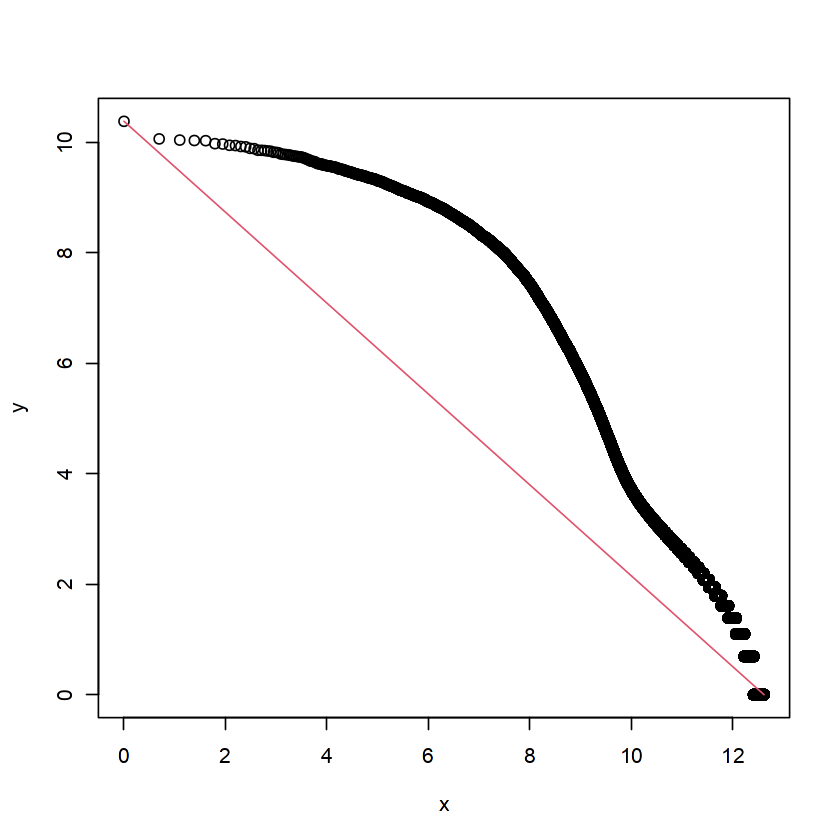

Warning message in create_seurat_object_from_seq_files(replica1, "M15", ribosome_removal = "rRNA", :
“Des gènes en double ont été trouvés et seront supprimés.”


 [1] "bs-ydzT" "bs-ydzT" "bs-ydzW" "bs-yetI" "bs-panE" "bs-yoyK" "bs-gswA"
 [8] "bs-ypuC" "bs-ispA" "bs-estA" "bs-epsK" "bs-epsJ" "bs-spsC"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


An object of class Seurat 
4493 features across 5461 samples within 1 assay 
Active assay: RNA (4493 features, 0 variable features)
 1 layer present: counts

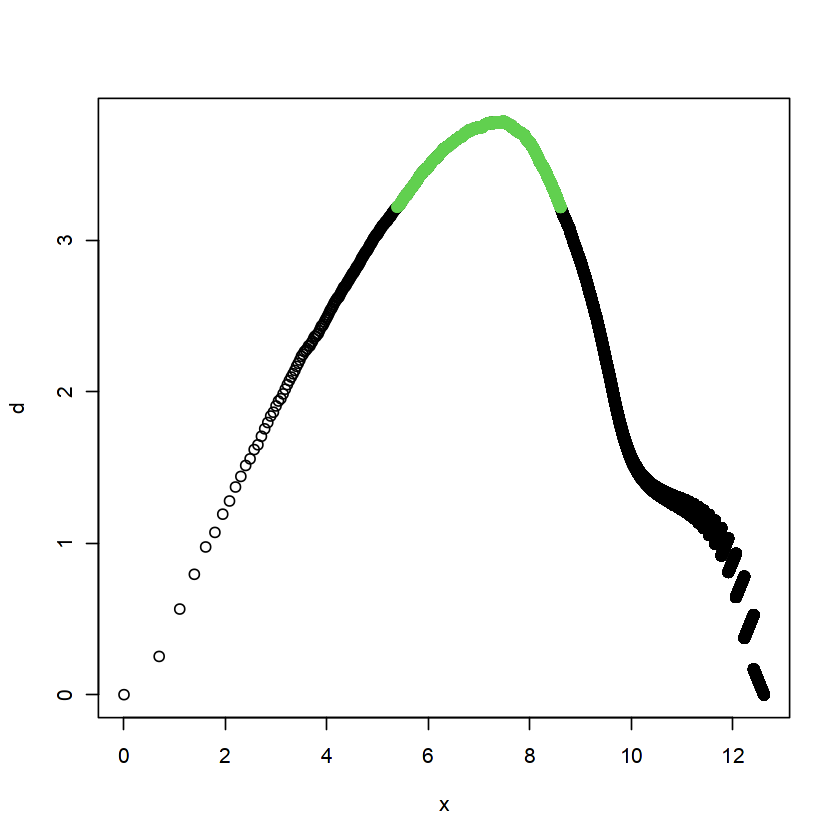

In [15]:
create_seurat_object_from_seq_files(replica1, 'M15', ribosome_removal = 'rRNA', threshold = 0.85, ribosome_file = ribosome_file)

In [ ]:
M15_  <- create_seurat_object_from_seq_files(replica1, 'M15', ribosome_removal = 'rRNA', threshold = NULL, ribosome_file = ribosome_file)




Warning message in create_seurat_object_from_seq_files(replica1, "M15", ribosome_removal = "rRNA", :
“Des gènes en double ont été trouvés et seront supprimés.”


 [1] "bs-ydzT" "bs-ydzT" "bs-ydzW" "bs-yetI" "bs-panE" "bs-yoyK" "bs-gswA"
 [8] "bs-ypuC" "bs-ispA" "bs-estA" "bs-epsK" "bs-epsJ" "bs-spsC"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


In [8]:
te

ERROR: Error: object 'te' not found


In [ ]:
create_seurat_object_from_seq_files(replica1, 'M15', ribosome_removal = 'rRNA', threshold = NULL, ribosome_file = ribosome_file)

Warning message in create_seurat_object_from_seq_files(replica1, "M15", ribosome_removal = "rRNA", :
“Des gènes en double ont été trouvés et seront supprimés.”


 [1] "bs-ydzT" "bs-ydzT" "bs-ydzW" "bs-yetI" "bs-panE" "bs-yoyK" "bs-gswA"
 [8] "bs-ypuC" "bs-ispA" "bs-estA" "bs-epsK" "bs-epsJ" "bs-spsC"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


In [ ]:
create_seurat_object_from_seq_files(replica1, 'M15', ribosome_removal = 'rRNA', threshold = 0.85, ribosome_file = ribosome_file)